## Installing required dependencies and dataset

In [1]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -q -U git+https://github.com/albumentations-team/albumentations
!pip install -q timm
!pip install -q --upgrade opencv-contrib-python

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052
Receiving objects: 100% (34052/34052), 52.31 MiB | 34.90 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 9.7 MB/s eta 0:00:00


## Importing required librareies

In [2]:
import os
import timm
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collecting dataset


In [4]:
train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=(-20 ,+20)),
            transforms.ToTensor()
            ])

valid_transforms = transforms.Compose([
        transforms.ToTensor()
])

In [5]:
train_folder_dir = '/content/Facial-Expression-Dataset/train'
valid_folder_dir = '/content/Facial-Expression-Dataset/validation'

In [6]:
train_set = ImageFolder(train_folder_dir, transform=train_transforms)
valid_set = ImageFolder(valid_folder_dir, transform=valid_transforms)

In [7]:
print(f"Number of examples in Training Set : {len(train_set)}")
print(f"Number of examples in Validation Set : {len(valid_set)}")

Number of examples in Training Set : 28821
Number of examples in Validation Set : 7066


Plotting images from training set

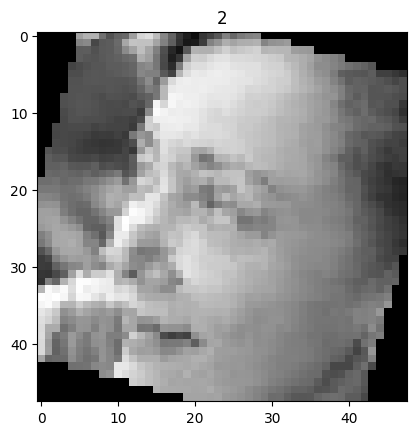

In [8]:
images, labels = train_set[5173]
plt.imshow(images.permute(1,2,0))
plt.title(labels)
plt.show()

In [9]:
print(train_set.class_to_idx)
no_classes = len(train_set.classes)
no_classes

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


7

# Assigning DataLoaders


In [10]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size = batch_size)

In [12]:
print(f"Number of batches in trainloader : {len(train_loader)}")
print(f"Number of batches in validloader : {len(valid_loader)}")

Number of batches in trainloader : 901
Number of batches in validloader : 221


In [13]:
for images, labels in train_loader:
  break
print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Creating Model

In [16]:
class FacialExpModel(nn.Module):
  def __init__(self):
    super(FacialExpModel, self).__init__()
    # Output without any activation function (raw)
    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes = 7)

  def forward(self, images, labels=None):
    logits = self.efficientnet(images)
    if labels!= None:
      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss
    return logits

In [17]:
model = FacialExpModel()
model.to(device)

FacialExpModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel

# Training and Evaluation Functions

In [18]:
def multiclass_accuracy(y_pred,y_true):
  top_p,top_class = y_pred.topk(1,dim = 1)
  correct = top_class == y_true.view(*top_class.shape)
  return torch.mean(correct.type(torch.FloatTensor))

In [19]:
def train_model(model, data_loader, optimizer, current_epoch):
  model.train()
  total_loss = 0.0
  total_acc = 0.0

  tk = tqdm(data_loader, desc = 'Epoch ' + ' (Train) ' + str(current_epoch) + '/' + str(num_epochs))
  for i, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc  += multiclass_accuracy(logits, labels)
    tk.set_postfix({'Loss:': '%6f' %float(total_loss/(i+1)), 'Acc' : '%6f' %float(total_acc/(i+1))})

  return total_loss/len(data_loader), total_acc/len(data_loader)

In [20]:
def eval_model(model, data_loader, current_epoch):

  model.eval()

  total_loss = 0.0
  total_acc = 0.0

  tk = tqdm(data_loader, desc = 'Epoch ' + ' (Valid) ' + str(current_epoch) + '/' + str(num_epochs))

  for i, data in enumerate(tk):

    images, labels = data
    images, labels = images.to(device), labels.to(device)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc  += multiclass_accuracy(logits, labels)

    tk.set_postfix({'Loss:': '%6f' %float(total_loss/(i+1)), 'Acc' : '%6f' %float(total_acc/(i+1))})

  return total_loss/len(data_loader), total_acc/len(data_loader)

# Create Training Loop

In [21]:
lr = 10e-3
num_epochs = 15

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
best_valid_loss = np.Inf
train_loss_list = []
valid_loss_list = []

train_acc_list = []
valid_acc_list = []
for epoch in range(num_epochs):
  train_loss, train_acc = train_model(model, train_loader, optimizer, epoch)
  valid_loss, valid_acc = eval_model(model, valid_loader, epoch)

  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)

  train_acc_list.append(train_acc)
  valid_acc_list.append(valid_acc)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'fer-eff.pth')
    print('Saving Model.....')
    best_valid_loss = valid_loss

Epoch  (Valid) 0/15: 100%|██████████| 221/221 [00:07<00:00, 27.77it/s, Loss:=1.589247, Acc=0.381069]


Saving Model.....


Epoch  (Valid) 1/15: 100%|██████████| 221/221 [00:09<00:00, 24.06it/s, Loss:=1.429367, Acc=0.465704]


Saving Model.....


Epoch  (Valid) 2/15: 100%|██████████| 221/221 [00:07<00:00, 28.54it/s, Loss:=1.356461, Acc=0.490841]


Saving Model.....


Epoch  (Valid) 3/15: 100%|██████████| 221/221 [00:08<00:00, 25.42it/s, Loss:=1.280326, Acc=0.527106]


Saving Model.....


Epoch  (Valid) 4/15: 100%|██████████| 221/221 [00:07<00:00, 28.53it/s, Loss:=1.223880, Acc=0.538059]


Saving Model.....


Epoch  (Valid) 6/15: 100%|██████████| 221/221 [00:09<00:00, 24.15it/s, Loss:=1.204570, Acc=0.541431]


Saving Model.....


Epoch  (Valid) 7/15: 100%|██████████| 221/221 [00:07<00:00, 28.18it/s, Loss:=1.179320, Acc=0.551742]


Saving Model.....


Epoch  (Valid) 9/15: 100%|██████████| 221/221 [00:08<00:00, 26.90it/s, Loss:=1.149624, Acc=0.565535]


Saving Model.....


Epoch  (Valid) 11/15: 100%|██████████| 221/221 [00:07<00:00, 29.82it/s, Loss:=1.122220, Acc=0.583373]


Saving Model.....


Epoch  (Valid) 14/15: 100%|██████████| 221/221 [00:08<00:00, 27.23it/s, Loss:=1.155185, Acc=0.569070]


## Visualzing Traing Accuracy and Loss curve

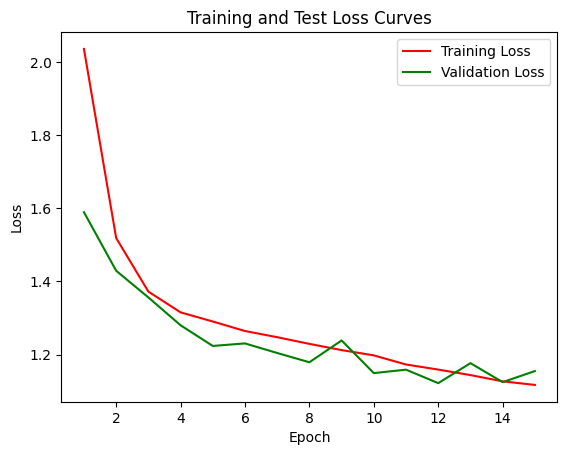

In [24]:
plt.plot(np.arange(1,num_epochs+1), train_loss_list, 'r', label='Training Loss')
plt.plot(np.arange(1,num_epochs+1), valid_loss_list, 'g', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()

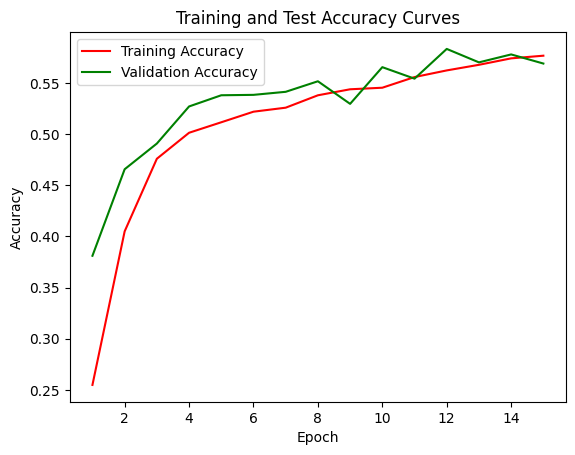

In [25]:
plt.plot(np.arange(1,num_epochs+1), train_acc_list, 'r', label='Training Accuracy')
plt.plot(np.arange(1,num_epochs+1), valid_acc_list, 'g', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curves')
plt.legend()
plt.show()

In [26]:
def view_classify(img, ps):
  classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  ps = ps.data.cpu().numpy().squeeze()
  img = img.numpy().transpose(1,2,0)
  fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
  ax1.imshow(img)
  ax1.axis('off')
  ax2.barh(classes, ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(classes)
  ax2.set_yticklabels(classes)
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)
  plt.tight_layout()
  return None

tensor([[0.0151, 0.0021, 0.0287, 0.8964, 0.0245, 0.0212, 0.0119]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


3

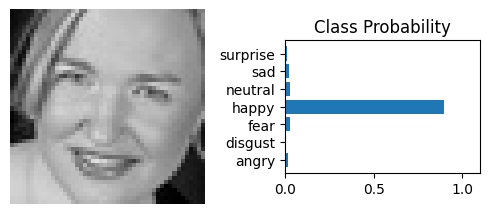

In [27]:
index = 3133

images, labels = valid_set[index]
model.load_state_dict(torch.load('/content/fer-eff.pth'))
logit = model(images.to(device).unsqueeze(0))
prediction = torch.softmax(logit,1)
view_classify(images, prediction)
print(prediction)
labels